In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive

/content/drive/MyDrive


In [3]:
# !pip install sentencepiece
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 71.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached Cython-0.29.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 130.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 73.6 MB/s eta 0:00:00
  Preparing metadat

In [4]:
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
import os
import json

In [5]:
# !pip install fasttext
# import fasttext
# from sklearn.cluster import KMeans
# import numpy as np
# from gensim import models

In [6]:
# model_path = '/content/drive/MyDrive/jolnon/cc.ko.100.bin'

# m_fasttext = models.fasttext.load_facebook_model(model_path)

In [7]:
import os
import json
import re
from zipfile import ZipFile

cond = re.compile('[가-힣]+')

def get_data_from_zip(zip_name):
    zip_file_path = '/content/drive/MyDrive/jolnon/' + zip_name + '.zip'
    extract_path = '/content/' + zip_name

    with ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    result = []
    for name in os.listdir(path=extract_path):
        file_path = os.path.join(extract_path, name)
        if os.path.isdir(file_path):
            for name in os.listdir(path=file_path):
                with open(file_path + '/' + name, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                    valid = []
                    for d in data['content'].split('\n'):
                        res = []
                        for word in d.split(' '):
                            if cond.match(word) != None:
                                res.append(word)
                        d = ' '.join(res)
                        if d and not d.replace(' ', '').isdecimal():
                            valid.append(d)
                    result.append('\n'.join([data['title']] + valid))
        else:
            with open(extract_path + '/' + name, 'r', encoding='utf-8') as f:
                data = json.load(f)
                valid = []
                for d in data['content'].split('\n'):
                    res = []
                    for word in d.split(' '):
                        if cond.match(word) != None:
                            res.append(word)
                    d = ' '.join(res)
                    if d and not d.replace(' ', '').isdecimal():
                        valid.append(d)
                result.append('\n'.join([data['title']] + valid))
    return result


In [8]:
import random
random.seed(42)
galleries = ['tree','baseball_high']
dataset = []
for e in galleries:
  dataset.append([get_data_from_zip(e)])
cocktail = []
for data in dataset:
  for sen in data:
    cocktail+=sen

In [9]:
def remove_words(sentence, word):
    return ' '.join([w.replace(word, '') for w in sentence.split()])
stopwords = ['-dc', 'official', 'App', '이미지' ,'순서','저장','.jpg','.png','.txt','.gif','ㅋㅋ','ㅋ','jpg','png','txt','gif','씨발']
for i in range(len(cocktail)):
  for j in range(len(stopwords)):
    cocktail[i] = remove_words(cocktail[i],stopwords[j])

In [10]:
import collections

def remove_top_n_words(data, n):
    words = [word for sentence in data for word in sentence.split(' ')]
    word_count = collections.Counter(words)
    top_n_words = [word for word, _ in word_count.most_common(n)]
    for i in range(len(data)):
        for word in top_n_words:
            if word=='':
                continue
            data[i] = remove_words(data[i], word)
    return data

def remove_empty_sentences(cocktail, real_labels):
  indices = [i for i, sentence in enumerate(cocktail) if sentence.strip() != '']
  cocktail = [cocktail[i] for i in indices]
  real_labels = [real_labels[i] for i in indices]
  return cocktail, real_labels


In [11]:
real_labels = []
for i in range(len(dataset)):
  real_labels += [i] * len(dataset[i][0])
cocktail = remove_top_n_words(cocktail, 0)
cocktail, real_labels = remove_empty_sentences(cocktail, real_labels)

In [12]:
# !pip install transformers
# from transformers import AutoModel, AutoTokenizer
# model = AutoModel.from_pretrained("klue/roberta-large")
# tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")

# model = AutoModel.from_pretrained("klue/bert-base")
# tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")
# bertopic_model_embed_token = BERTopic(embedding_model=model,
#                                       vectorizer_model=vectorizer,
#                                       ctfidf_model=ctfidf_model,
#                                       nr_topics=100,
#                                       top_n_words=1,
#                                       calculate_probabilities=False)

In [13]:
from bertopic.vectorizers import ClassTfidfTransformer
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
bertopic_model_embed_token = BERTopic(language='multilingual',
                          nr_topics=100,
                          top_n_words=1)
topics, _ = bertopic_model_embed_token.fit_transform(cocktail)

In [14]:
topic_info = bertopic_model_embed_token.get_topic_info()
number_of_topics = len(topic_info) - 1
print(f"생성된 주제의 수: {number_of_topics}")
lst = []
for index, row in topic_info.iterrows():
    topic_num = row['Topic']
    if topic_num != -1:
        topic_name = row['Name']
        pure_topic_name = "_".join(topic_name.split("_")[1:])
        lst.append(pure_topic_name)

생성된 주제의 수: 99


In [15]:
### Reducing outliers
topics = bertopic_model_embed_token.reduce_outliers(cocktail, topics, strategy="c-tf-idf", threshold=0.1)
topics = bertopic_model_embed_token.reduce_outliers(cocktail, topics, strategy="distributions")

In [16]:
hierarchical_topics = bertopic_model_embed_token.hierarchical_topics(cocktail)

100%|██████████| 98/98 [00:00<00:00, 122.82it/s]


In [17]:
# bertopic_model_embed_token.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [18]:
verify = True
table = [[0 for r in range(2)] for t in range(max([int(x) for x in hierarchical_topics['Parent_ID']]) + 1)]
if verify:
  for j in range(number_of_topics):
    for i in range(len(topics)):
      if topics[i]==j:
        table[j][real_labels[i]]+=1
  for j in range(number_of_topics, len(table)):
    row = hierarchical_topics[hierarchical_topics['Parent_ID'] == str(j)].iloc[0]
    left, right = int(row['Child_Left_ID']), int(row['Child_Right_ID'])
    for i in range(len(table[0])):
      table[j][i] += table[left][i] + table[right][i]

In [19]:
df = hierarchical_topics
selected_topics_ids = set()
for index, row in df[df['Distance'] >= 1].iterrows():
    left_child = df[df['Parent_ID'] == row['Child_Left_ID']]
    if not left_child.empty and left_child.iloc[0]['Distance'] < 1:
        selected_topics_ids.add(row['Child_Left_ID'])

    right_child = df[df['Parent_ID'] == row['Child_Right_ID']]
    if not right_child.empty and right_child.iloc[0]['Distance'] < 1:
        selected_topics_ids.add(row['Child_Right_ID'])
selected_topics_ids = list(selected_topics_ids)

In [20]:
post_counts = [0 for i in range(number_of_topics)]
for i in range(len(post_counts)):
    post_counts[i] = topics.count(i)

In [21]:
selected_topic_names=[]
for topic_id in selected_topics_ids:
    topic_name = df[df['Parent_ID'] == topic_id]['Parent_Name'].iloc[0]
    selected_topic_names.append(topic_name)

In [22]:
for i in range(len(selected_topic_names)):
  print(selected_topic_names[i], selected_topics_ids[i])


나무 123
딸기 165
개잘치네 159
김혜성 144
감다살 161
이름이 100
홈런 131
날려버려라 167
투표 164
야구 102
꽃이 114
알로카시아 163
버섯 133
9개구단 158
이거 117
자취생 154
바질 150
문학에서 115
식물 119
귀엽다 140
인터뷰 166
제라늄 145
존나 121
무늬 153
52 146
냄새 155
뿌리가 162
jpg 127
아오 126
gif 122


In [25]:
ord = [0,0,1,1,1,0,1,1,1,1,0,0,0,1,2,2,0,1,0,0,1,0,2,0,2,0,0,2,2,2,]

In [24]:
assert False
# 아래 chosen_topics를 설정한 후 실행하세요

AssertionError: ignored

In [ ]:
# hierarchical_topics

In [26]:
from scipy.stats import norm
import numpy as np

def plot_gaussian(data1, data2, data3):
    print(data1, data2, data3)
    mu1, std1 = np.mean(data1), np.std(data1)
    mu2, std2 = np.mean(data2), np.std(data2)
    mu3, std3 = np.mean(data3), np.std(data3)

    xmin = min(min(data1), min(data2), min(data3))
    xmax = max(max(data1), max(data2), max(data3))
    x = np.linspace(0, 1, 1000)

    p1 = norm.pdf(x, mu1, std1)
    p2 = norm.pdf(x, mu2, std2)
    p3 = norm.pdf(x, mu3, std3)

    plt.plot(x, p1, 'r', linewidth=2, label=f"Data1: µ={mu1:.2f}, σ={std1:.2f}")
    plt.plot(x, p2, 'g', linewidth=2, label=f"Data2: µ={mu2:.2f}, σ={std2:.2f}")
    plt.plot(x, p3, 'b', linewidth=2, label=f"Data3: µ={mu3:.2f}, σ={std3:.2f}")


    plt.title("Gaussian Distributions")
    plt.legend()
    plt.show()

# plot_gaussian(*ratios)

In [27]:
import warnings
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

def clusterByHand2(table, selected_topics_ids, selected_topic_names, galleries, post_counts, ord):
  selected_topic_counts = [[0, 0] for _ in range(len(selected_topics_ids))]
  for i in range(len(selected_topics_ids)):
    selected_topic_counts[i][0] += table[int(selected_topics_ids[i])][0]
    selected_topic_counts[i][1] += table[int(selected_topics_ids[i])][1]
  dic = dict()
  n_clusters = len(galleries) + 1
  idx2name = dict(zip(selected_topics_ids,selected_topic_names))
  name2idx = dict(zip(selected_topic_names,selected_topics_ids))
  clustered_topics_name=[[],[],[]]
  for i in range(len(ord)):
    clustered_topics_name[ord[i]].append(selected_topic_names[i])

  clustered_topics_count = [[] for _ in range(n_clusters)]
  clustered_topics = [[] for _ in range(n_clusters)]
  for i in range(len(clustered_topics_name)):
    for ele in clustered_topics_name[i]:
      clustered_topics[i].append(name2idx[ele])
  for r in clustered_topics_name:
    print(r)
  cluster_sums = []
  for idx, cluster in enumerate(clustered_topics):
    total_sum = 0
    for parent_id in cluster:
      row = hierarchical_topics[hierarchical_topics['Parent_ID'] == parent_id].iloc[0]
      topic_ids = row['Topics']
      cluster_sum = sum(post_counts[topic_id] for topic_id in topic_ids)
      clustered_topics_count[idx].append(cluster_sum)
      total_sum += cluster_sum
    cluster_sums.append(total_sum)
  if verify:
    clustered_count = [[0, 0] for _ in range(n_clusters)]
    for i in range(n_clusters):
      for j in clustered_topics[i]:
        clustered_count[i][0] += table[int(j)][0]
        clustered_count[i][1] += table[int(j)][1]

    for i in range(n_clusters):
      l, r = clustered_count[i][0], clustered_count[i][1]
      for j in range(len(clustered_topics[i])):
        k = clustered_topics[i][j]
        l, r = table[int(k)][0], table[int(k)][1]
    clusters = []

    for i in range(n_clusters):
      cluster_info = {}
      l, r = clustered_count[i][0], clustered_count[i][1]
      cluster_info['name'] = f'Cluster #{i+1}'
      cluster_info['value'] = l + r
      cluster_info['distribution'] = [100 * l / (l + r), 100 * r / (l + r)]

      topics_list = []
      for j in range(len(clustered_topics[i])):
        topic_info = {}
        k = clustered_topics[i][j]
        l, r = table[int(k)][0], table[int(k)][1]
        topic_info['name'] = clustered_topics_name[i][j]
        topic_info['value'] = l + r
        topic_info['distribution'] = [100 * l / (l + r), 100 * r / (l + r)]
        topics_list.append(topic_info)

      cluster_info['topics'] = topics_list
      clusters.append(cluster_info)

    font_path = '/content/drive/MyDrive/NanumSquareRoundR.ttf'
    fontprop = fm.FontProperties(fname=font_path, size=10)
    plt.rcParams["font.family"] = fontprop.get_name()
    plt.rcParams['axes.unicode_minus'] = False

    def sort_topics_by_distribution(cluster):
      cluster['topics'] = sorted(cluster['topics'], key=lambda x: x['distribution'][0], reverse=True)

    for cluster in clusters:
      sort_topics_by_distribution(cluster)

    # 서브플롯을 위한 열의 수 계산
    n_cols = len(clusters)
    fig, axes = plt.subplots(1, n_cols, figsize=(10 * n_cols, 6))  # n_cols 만큼의 서브플롯 생성

    for idx, cluster in enumerate(clusters):
        ax = axes[idx]
        y_positions = []
        y_labels = []
        current_y = 0
        bar_width = 0.4

        y_positions.append(current_y)
        y_labels.append(cluster['name'])
        for topic in cluster['topics']:
            current_y -= 1
            y_positions.append(current_y)
            y_labels.append(topic['name'])
            ax.barh(current_y, topic['distribution'][0], color='C0', height=bar_width, label=topic['name'])
            # ax.barh(current_y, topic['distribution'][1], color='g', left=topic['distribution'][0], height=bar_width)
        current_y -= 2

        galleries2 = galleries.copy()
        galleries2.append('Etc')
        ax.set_yticks(y_positions)
        ax.set_yticklabels(y_labels, fontproperties=fontprop)
        ax.set_xlabel('실제 분포', fontproperties=fontprop)
        ax.set_title(f'각 주제 별 {galleries2[0]} 커뮤니티 비율', fontproperties=fontprop)
        # ax.legend(loc='upper right', prop=fontprop)
        ax.set_xlim([0,100])
    plt.tight_layout()
    plt.show()

    return clustered_topics

['나무', '딸기', '이름이', '꽃이', '알로카시아', '버섯', '바질', '식물', '귀엽다', '제라늄', '무늬', '냄새', '뿌리가']
['개잘치네', '김혜성', '감다살', '홈런', '날려버려라', '투표', '야구', '9개구단', '문학에서', '인터뷰']
['이거', '자취생', '존나', '52', 'jpg', '아오', 'gif']


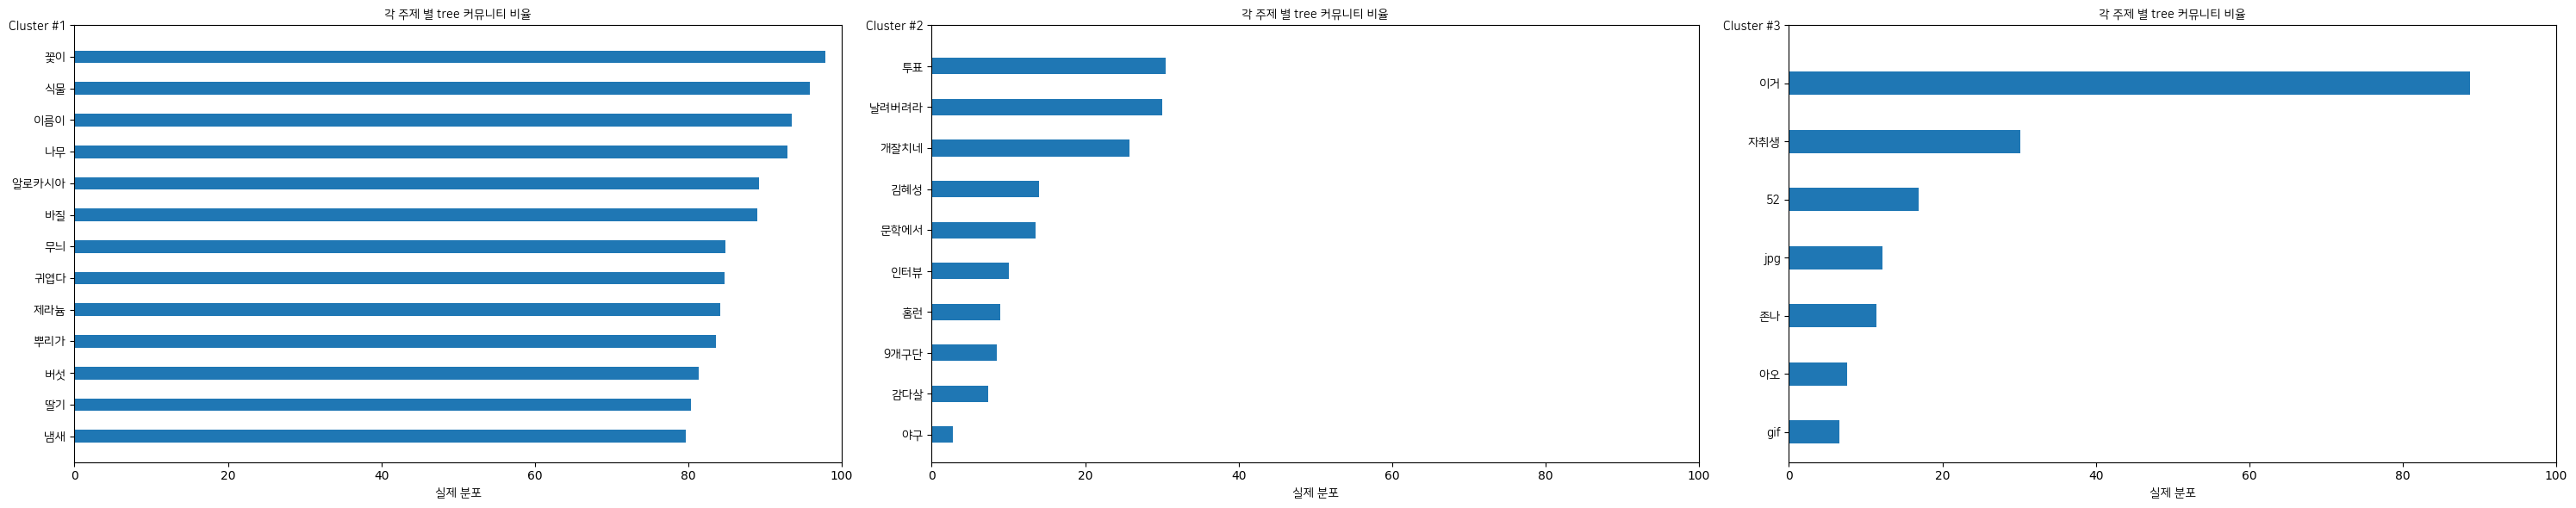

In [28]:
clustered_topics_ids = clusterByHand2(table, selected_topics_ids, selected_topic_names, galleries, post_counts, ord)
ratios = [[] for i in range(3)]
for i in range(3):
  ratio = []

  topics_list = []
  for j in range(len(clustered_topics_ids[i])):
    k = clustered_topics_ids[i][j]
    l, r = table[int(k)][0], table[int(k)][1]
    ratio.append(l / (l + r))
  ratios[i] = ratio

[0.9297297297297298, 0.8031914893617021, 0.9355371900826446, 0.978319783197832, 0.8924302788844621, 0.8135593220338984, 0.8906752411575563, 0.9590361445783132, 0.84765625, 0.8421052631578947, 0.8481481481481481, 0.796875, 0.8366666666666667] [0.25742574257425743, 0.13989637305699482, 0.07312614259597806, 0.08979591836734693, 0.3, 0.3047158403869408, 0.027131782945736434, 0.08484848484848485, 0.13496932515337423, 0.10038610038610038] [0.8873575891216464, 0.3014705882352941, 0.11452682338758288, 0.16883116883116883, 0.12195121951219512, 0.07570977917981073, 0.06570841889117043]


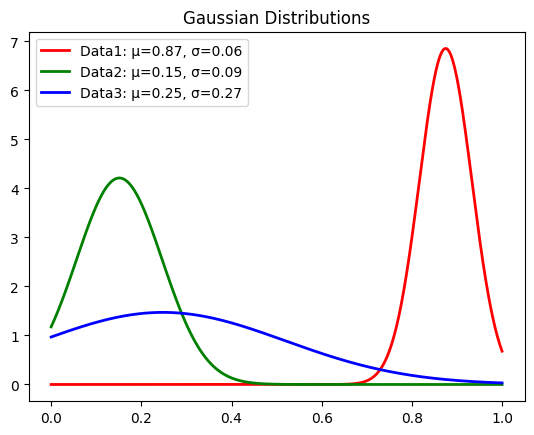

In [29]:
plot_gaussian(*ratios)